In [2]:
# import libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import PIL
from PIL import Image
from tqdm.auto import tqdm
from torchinfo import summary
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

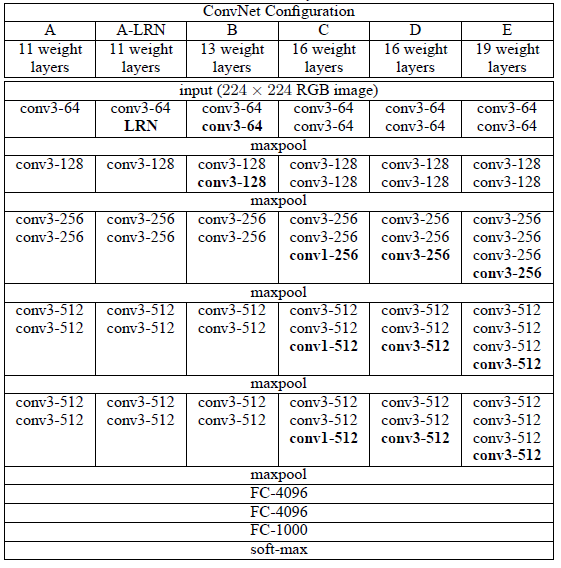

In [4]:
class LocalResponseNorm(nn.Module):
    def __init__(self, size, k=2.0, alpha=1e-4, beta=0.75):
        super(LocalResponseNorm, self).__init__()
        self.size = size
        self.k = k
        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        _, C, _, _ = x.size()
        half_size = self.size // 2
        square_sum = torch.zeros_like(x)
        
        for i in range(C):
            left = max(0, i - half_size)
            right = min(C, i + half_size)
            square_sum[:, i, :, :] = torch.sum(x[:, left:right, :, :] ** 2, dim=1)
        scale = self.k + self.alpha * square_sum
        scale = scale ** self.beta
        x = x / scale
        return x

In [5]:
class VGGNet_11(nn.Module):
    def __init__(self):
        super(VGGNet_11, self).__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (64, 112, 112)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (128, 56, 56)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (256, 28, 28)
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (512, 14, 14)
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# (512, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (512, 7, 7)
        )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGGNet_11().to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet_11                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          590,08

In [6]:
class VGGNet_11_LRN(nn.Module):
    def __init__(self):
        super(VGGNet_11_LRN, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            LocalResponseNorm(5),
            nn.MaxPool2d(kernel_size=2, stride=2), # (64, 112, 112)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (128, 56, 56)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (256, 28, 28)
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (512, 14, 14)
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# (512, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (512, 7, 7)
        )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGGNet_11_LRN().to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet_11_LRN                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─LocalResponseNorm: 2-3            [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-6                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-7                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-8                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-9                         [1, 256, 56, 56]          --
│  

In [7]:
class VGGNet_13(nn.Module):
    def __init__(self):
        super(VGGNet_13, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (64, 112, 112)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (128, 56, 56)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (256, 28, 28)
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (512, 14, 14)
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# (512, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (512, 7, 7)
        )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGGNet_13().to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet_13                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --

In [8]:
class VGGNet_16(nn.Module):
    def __init__(self):
        super(VGGNet_16, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (64, 112, 112)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (128, 56, 56)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (256, 28, 28)
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (512, 14, 14)
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (512, 7, 7)
        )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGGNet_16().to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet_16                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --

In [9]:
class VGGNet_19(nn.Module):
    def __init__(self):
        super(VGGNet_19, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # (64, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (64, 112, 112)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # (128, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (128, 56, 56)
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # (256, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (256, 28, 28)
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (512, 14, 14)
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# (512, 14, 14)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # (512, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (512, 7, 7)
        )

        self.classifier = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = VGGNet_19().to(device)
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGGNet_19                                [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_data(root_dir):
    classes = os.listdir(root_dir)
    cls_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    images = []
    labels = []

    for cls_name in classes:
        cls_dir = os.path.join(root_dir, cls_name)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            images.append(img_path)
            labels.append(cls_to_idx[cls_name])

    return images, labels

# Define transformations for the original images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim


# 데이터셋 및 데이터 로더 설정
train_dataset = ImageFolder(root='E:\\puzzle\\data\\ImageNet10\\train', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = ImageFolder(root='E:\\puzzle\\data\\ImageNet10\\val', transform=valid_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


# Define the device to be used (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = VGGNet_11().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch} [Training]', leave=False)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix({
            'Loss': running_loss / total,
            'Accuracy': correct / total
        })

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    
def validate(model, val_loader, criterion, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch} [Validation]', leave=False)
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_loader_tqdm.set_postfix({
                'Loss': running_loss / total,
                'Accuracy': correct / total
            })

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / len(val_loader.dataset)
    print(f'Epoch {epoch}, Validation loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return epoch_acc

# Main training loop
num_epochs = 76
best_valid_acc = 0.0
learning_rate = 0.01

for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, epoch)
    valid_acc = validate(model, val_loader, criterion, epoch)
    
    # Update learning rate if validation accuracy does not improve
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
    else:
        learning_rate /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate
    
    # Stop training if learning rate is too low
    if learning_rate < 1e-6:
        break


Epoch 0 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 0, Training loss: 2.3037, Accuracy: 0.1009


Epoch 0 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 0, Validation loss: 2.3030, Accuracy: 0.1000


Epoch 1 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 1, Training loss: 2.2740, Accuracy: 0.1191


Epoch 1 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 1, Validation loss: 2.0913, Accuracy: 0.2350


Epoch 2 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 2, Training loss: 1.8611, Accuracy: 0.3043


Epoch 2 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 2, Validation loss: 1.6331, Accuracy: 0.3981


Epoch 3 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 3, Training loss: 1.6059, Accuracy: 0.4230


Epoch 3 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 3, Validation loss: 1.3971, Accuracy: 0.4769


Epoch 4 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 4, Training loss: 1.3816, Accuracy: 0.5066


Epoch 4 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 4, Validation loss: 1.4116, Accuracy: 0.5519


Epoch 5 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 5, Training loss: 1.2119, Accuracy: 0.5743


Epoch 5 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 5, Validation loss: 1.1188, Accuracy: 0.6108


Epoch 6 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 6, Training loss: 1.0708, Accuracy: 0.6340


Epoch 6 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 6, Validation loss: 1.0399, Accuracy: 0.6473


Epoch 7 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 7, Training loss: 0.9196, Accuracy: 0.6863


Epoch 7 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 7, Validation loss: 0.9050, Accuracy: 0.6935


Epoch 8 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 8, Training loss: 0.7915, Accuracy: 0.7329


Epoch 8 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 8, Validation loss: 0.8589, Accuracy: 0.7046


Epoch 9 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 9, Training loss: 0.6557, Accuracy: 0.7772


Epoch 9 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 9, Validation loss: 0.8393, Accuracy: 0.7177


Epoch 10 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 10, Training loss: 0.5544, Accuracy: 0.8139


Epoch 10 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 10, Validation loss: 1.1023, Accuracy: 0.6792


Epoch 11 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 11, Training loss: 0.2357, Accuracy: 0.9237


Epoch 11 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 11, Validation loss: 0.8519, Accuracy: 0.7650


Epoch 12 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 12, Training loss: 0.1484, Accuracy: 0.9508


Epoch 12 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 12, Validation loss: 0.9069, Accuracy: 0.7662


Epoch 13 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 13, Training loss: 0.0966, Accuracy: 0.9690


Epoch 13 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 13, Validation loss: 1.0320, Accuracy: 0.7642


Epoch 14 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 14, Training loss: 0.0641, Accuracy: 0.9827


Epoch 14 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 14, Validation loss: 1.0279, Accuracy: 0.7704


Epoch 15 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 15, Training loss: 0.0617, Accuracy: 0.9817


Epoch 15 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 15, Validation loss: 1.0462, Accuracy: 0.7677


Epoch 16 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 16, Training loss: 0.0566, Accuracy: 0.9841


Epoch 16 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 16, Validation loss: 1.0486, Accuracy: 0.7685


Epoch 17 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 17, Training loss: 0.0599, Accuracy: 0.9821


Epoch 17 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 17, Validation loss: 1.0489, Accuracy: 0.7685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


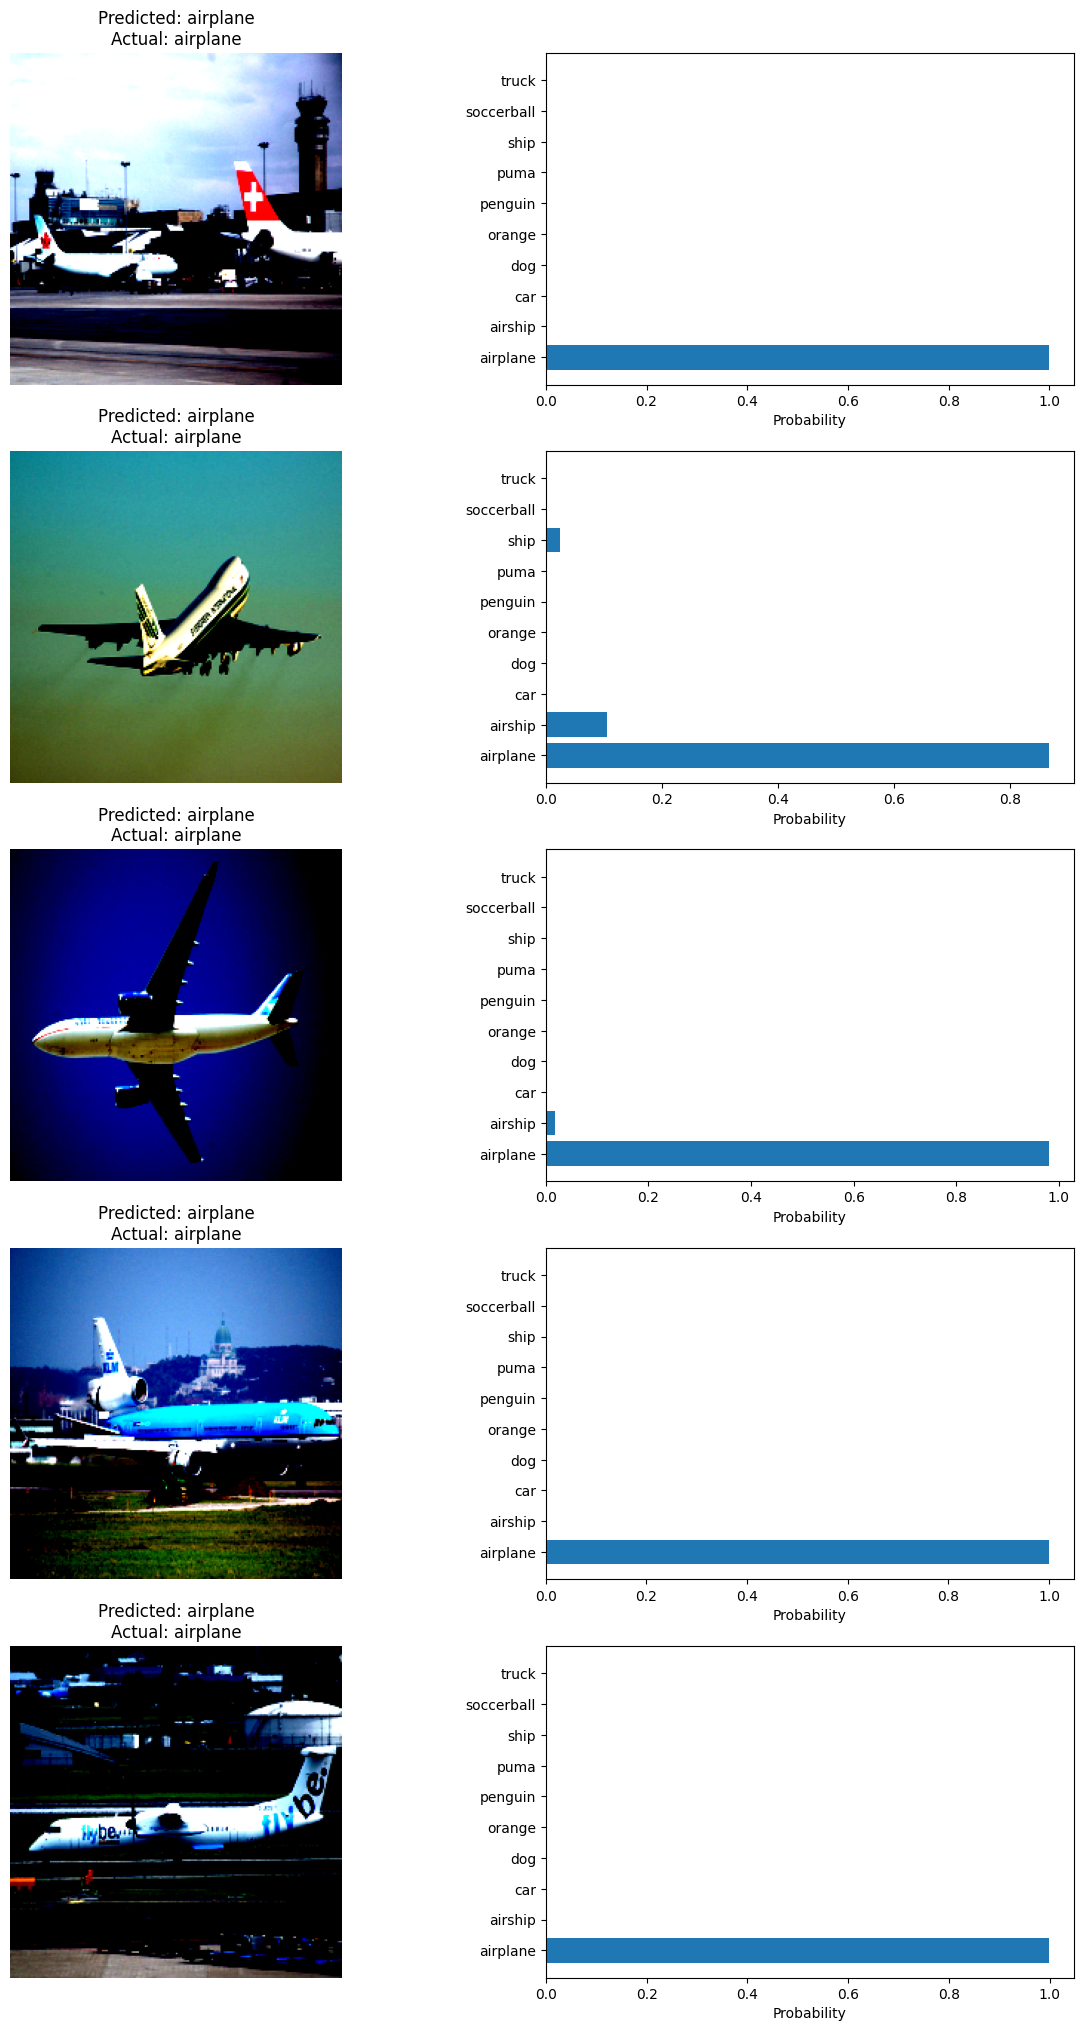

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Define a function to visualize the predictions
def visualize_predictions(model, loader, device, class_names, num_images=5):
    model.eval()
    images_so_far = 0

    plt.figure(figsize=(15, num_images * 5))

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                images_so_far += 1
                if images_so_far > num_images:
                    return
                
                plt.subplot(num_images, 2, 2 * images_so_far - 1)
                plt.imshow(images.cpu().data[j].permute(1, 2, 0).numpy())
                plt.title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
                plt.axis('off')

                plt.subplot(num_images, 2, 2 * images_so_far)
                probabilities = torch.nn.functional.softmax(outputs[j], dim=0)
                plt.barh(range(len(class_names)), probabilities.cpu().numpy())
                plt.yticks(range(len(class_names)), class_names)
                plt.xlabel('Probability')

# Assuming class_names is a list of class names corresponding to the dataset
class_names = train_dataset.classes

# Visualize predictions on validation set
visualize_predictions(model, val_loader, device, class_names, num_images=5)


In [27]:
torch.save(model.state_dict(), 'vgg11_best_model.pth')

In [30]:
# Load weight of VGG11 and freeze for Transfer learning VGG16

model_vgg16 = VGGNet_16().to(device)

vgg11_state_dict = torch.load('vgg11_best_model.pth')
vgg16_state_dict = model_vgg16.state_dict()

for name, param in vgg11_state_dict.items():
    if name in vgg16_state_dict:
        if vgg16_state_dict[name].shape == param.shape:
            vgg16_state_dict[name] = param

model_vgg16.load_state_dict(vgg16_state_dict)

# Freeze VGG11 layers
for name, param in model_vgg16.named_parameters():
    if 'block_1.0' in name or 'block_2.0' in name or 'block_3.0' in name or 'block_3.1' in name or 'block_4.0' in name or 'block_4.1' in name or 'block_5.0' in name or 'block_5.1' in name:
        param.requires_grad = False

# Only fine-tune the classifier part and the additional layers in VGG16
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model_vgg16.parameters()), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Fine-tune the VGG16 model
num_epochs = 50
best_valid_acc = 0.0

for epoch in range(num_epochs):
    train(model_vgg16, train_loader, criterion, optimizer, epoch)
    valid_acc = validate(model_vgg16, val_loader, criterion, epoch)
    
    scheduler.step()
    
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model_vgg16.state_dict(), 'vgg16_best_model.pth')
    
    if optimizer.param_groups[0]['lr'] < 1e-6:
        break


Epoch 0 [Training]:   0%|          | 0/325 [00:11<?, ?it/s]

Epoch 0, Training loss: 2.1521, Accuracy: 0.1797


Epoch 0 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 0, Validation loss: 1.5506, Accuracy: 0.4631


Epoch 1 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 1, Training loss: 1.1971, Accuracy: 0.5913


Epoch 1 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 1, Validation loss: 0.9993, Accuracy: 0.6562


Epoch 2 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 2, Training loss: 0.8026, Accuracy: 0.7291


Epoch 2 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 2, Validation loss: 0.9158, Accuracy: 0.6877


Epoch 3 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 3, Training loss: 0.5977, Accuracy: 0.7943


Epoch 3 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 3, Validation loss: 0.9665, Accuracy: 0.6865


Epoch 4 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 4, Training loss: 0.4268, Accuracy: 0.8541


Epoch 4 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 4, Validation loss: 1.0108, Accuracy: 0.7027


Epoch 5 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 5, Training loss: 0.3100, Accuracy: 0.8953


Epoch 5 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 5, Validation loss: 1.0908, Accuracy: 0.6942


Epoch 6 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 6, Training loss: 0.2419, Accuracy: 0.9196


Epoch 6 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 6, Validation loss: 1.2708, Accuracy: 0.6988


Epoch 7 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 7, Training loss: 0.2127, Accuracy: 0.9304


Epoch 7 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 7, Validation loss: 1.1008, Accuracy: 0.7092


Epoch 8 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 8, Training loss: 0.1585, Accuracy: 0.9499


Epoch 8 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 8, Validation loss: 1.4126, Accuracy: 0.7142


Epoch 9 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 9, Training loss: 0.1284, Accuracy: 0.9599


Epoch 9 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 9, Validation loss: 1.4643, Accuracy: 0.6950


Epoch 10 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 10, Training loss: 0.1289, Accuracy: 0.9582


Epoch 10 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 10, Validation loss: 1.5261, Accuracy: 0.6815


Epoch 11 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 11, Training loss: 0.1180, Accuracy: 0.9623


Epoch 11 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 11, Validation loss: 1.2382, Accuracy: 0.7077


Epoch 12 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 12, Training loss: 0.0891, Accuracy: 0.9715


Epoch 12 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 12, Validation loss: 1.4503, Accuracy: 0.7173


Epoch 13 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 13, Training loss: 0.0959, Accuracy: 0.9703


Epoch 13 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 13, Validation loss: 1.5259, Accuracy: 0.7162


Epoch 14 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 14, Training loss: 0.0740, Accuracy: 0.9783


Epoch 14 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 14, Validation loss: 1.3911, Accuracy: 0.7227


Epoch 15 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 15, Training loss: 0.0768, Accuracy: 0.9764


Epoch 15 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 15, Validation loss: 1.5629, Accuracy: 0.6935


Epoch 16 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 16, Training loss: 0.0752, Accuracy: 0.9767


Epoch 16 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 16, Validation loss: 1.6151, Accuracy: 0.7027


Epoch 17 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 17, Training loss: 0.0426, Accuracy: 0.9865


Epoch 17 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 17, Validation loss: 1.4175, Accuracy: 0.7304


Epoch 18 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 18, Training loss: 0.0603, Accuracy: 0.9831


Epoch 18 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 18, Validation loss: 1.3769, Accuracy: 0.7338


Epoch 19 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 19, Training loss: 0.0272, Accuracy: 0.9919


Epoch 19 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 19, Validation loss: 1.4047, Accuracy: 0.7308


Epoch 20 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 20, Training loss: 0.0366, Accuracy: 0.9878


Epoch 20 [Validation]:   0%|          | 0/82 [00:11<?, ?it/s]

Epoch 20, Validation loss: 1.4166, Accuracy: 0.7192


Epoch 21 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 21, Training loss: 0.0372, Accuracy: 0.9887


Epoch 21 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 21, Validation loss: 1.3938, Accuracy: 0.7158


Epoch 22 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 22, Training loss: 0.0316, Accuracy: 0.9909


Epoch 22 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 22, Validation loss: 1.5707, Accuracy: 0.7281


Epoch 23 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 23, Training loss: 0.0410, Accuracy: 0.9884


Epoch 23 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 23, Validation loss: 1.5374, Accuracy: 0.7323


Epoch 24 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 24, Training loss: 0.0354, Accuracy: 0.9888


Epoch 24 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 24, Validation loss: 1.4607, Accuracy: 0.7215


Epoch 25 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 25, Training loss: 0.0407, Accuracy: 0.9888


Epoch 25 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 25, Validation loss: 1.5557, Accuracy: 0.7315


Epoch 26 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 26, Training loss: 0.0252, Accuracy: 0.9912


Epoch 26 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 26, Validation loss: 1.4776, Accuracy: 0.7331


Epoch 27 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 27, Training loss: 0.0319, Accuracy: 0.9903


Epoch 27 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 27, Validation loss: 1.4817, Accuracy: 0.7335


Epoch 28 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 28, Training loss: 0.0396, Accuracy: 0.9891


Epoch 28 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 28, Validation loss: 1.5167, Accuracy: 0.7123


Epoch 29 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 29, Training loss: 0.0357, Accuracy: 0.9898


Epoch 29 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 29, Validation loss: 1.6631, Accuracy: 0.7092


Epoch 30 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 30, Training loss: 0.0097, Accuracy: 0.9970


Epoch 30 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 30, Validation loss: 1.5059, Accuracy: 0.7300


Epoch 31 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 31, Training loss: 0.0046, Accuracy: 0.9988


Epoch 31 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 31, Validation loss: 1.5136, Accuracy: 0.7304


Epoch 32 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 32, Training loss: 0.0022, Accuracy: 0.9996


Epoch 32 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 32, Validation loss: 1.5274, Accuracy: 0.7323


Epoch 33 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 33, Training loss: 0.0031, Accuracy: 0.9991


Epoch 33 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 33, Validation loss: 1.5378, Accuracy: 0.7327


Epoch 34 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 34, Training loss: 0.0021, Accuracy: 0.9996


Epoch 34 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 34, Validation loss: 1.5409, Accuracy: 0.7346


Epoch 35 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 35, Training loss: 0.0016, Accuracy: 0.9998


Epoch 35 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 35, Validation loss: 1.5625, Accuracy: 0.7350


Epoch 36 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 36, Training loss: 0.0016, Accuracy: 0.9995


Epoch 36 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 36, Validation loss: 1.5628, Accuracy: 0.7346


Epoch 37 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 37, Training loss: 0.0011, Accuracy: 0.9998


Epoch 37 [Validation]:   0%|          | 0/82 [00:08<?, ?it/s]

Epoch 37, Validation loss: 1.5798, Accuracy: 0.7350


Epoch 38 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 38, Training loss: 0.0014, Accuracy: 0.9996


Epoch 38 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 38, Validation loss: 1.5788, Accuracy: 0.7369


Epoch 39 [Training]:   0%|          | 0/325 [00:08<?, ?it/s]

Epoch 39, Training loss: 0.0009, Accuracy: 0.9999


Epoch 39 [Validation]:   0%|          | 0/82 [00:13<?, ?it/s]

Epoch 39, Validation loss: 1.5834, Accuracy: 0.7362


Epoch 40 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 40, Training loss: 0.0007, Accuracy: 1.0000


Epoch 40 [Validation]:   0%|          | 0/82 [00:10<?, ?it/s]

Epoch 40, Validation loss: 1.5859, Accuracy: 0.7369


Epoch 41 [Training]:   0%|          | 0/325 [00:10<?, ?it/s]

Epoch 41, Training loss: 0.0010, Accuracy: 0.9998


Epoch 41 [Validation]:   0%|          | 0/82 [00:10<?, ?it/s]

Epoch 41, Validation loss: 1.5934, Accuracy: 0.7365


Epoch 42 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 42, Training loss: 0.0009, Accuracy: 0.9998


Epoch 42 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 42, Validation loss: 1.5812, Accuracy: 0.7385


Epoch 43 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 43, Training loss: 0.0008, Accuracy: 0.9999


Epoch 43 [Validation]:   0%|          | 0/82 [00:10<?, ?it/s]

Epoch 43, Validation loss: 1.5790, Accuracy: 0.7388


Epoch 44 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 44, Training loss: 0.0016, Accuracy: 0.9998


Epoch 44 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 44, Validation loss: 1.5808, Accuracy: 0.7388


Epoch 45 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 45, Training loss: 0.0007, Accuracy: 0.9998


Epoch 45 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 45, Validation loss: 1.5923, Accuracy: 0.7381


Epoch 46 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 46, Training loss: 0.0010, Accuracy: 0.9999


Epoch 46 [Validation]:   0%|          | 0/82 [00:10<?, ?it/s]

Epoch 46, Validation loss: 1.5691, Accuracy: 0.7423


Epoch 47 [Training]:   0%|          | 0/325 [00:10<?, ?it/s]

Epoch 47, Training loss: 0.0009, Accuracy: 0.9998


Epoch 47 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 47, Validation loss: 1.5783, Accuracy: 0.7400


Epoch 48 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 48, Training loss: 0.0005, Accuracy: 1.0000


Epoch 48 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 48, Validation loss: 1.5830, Accuracy: 0.7400


Epoch 49 [Training]:   0%|          | 0/325 [00:09<?, ?it/s]

Epoch 49, Training loss: 0.0009, Accuracy: 0.9998


Epoch 49 [Validation]:   0%|          | 0/82 [00:09<?, ?it/s]

Epoch 49, Validation loss: 1.5879, Accuracy: 0.7385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


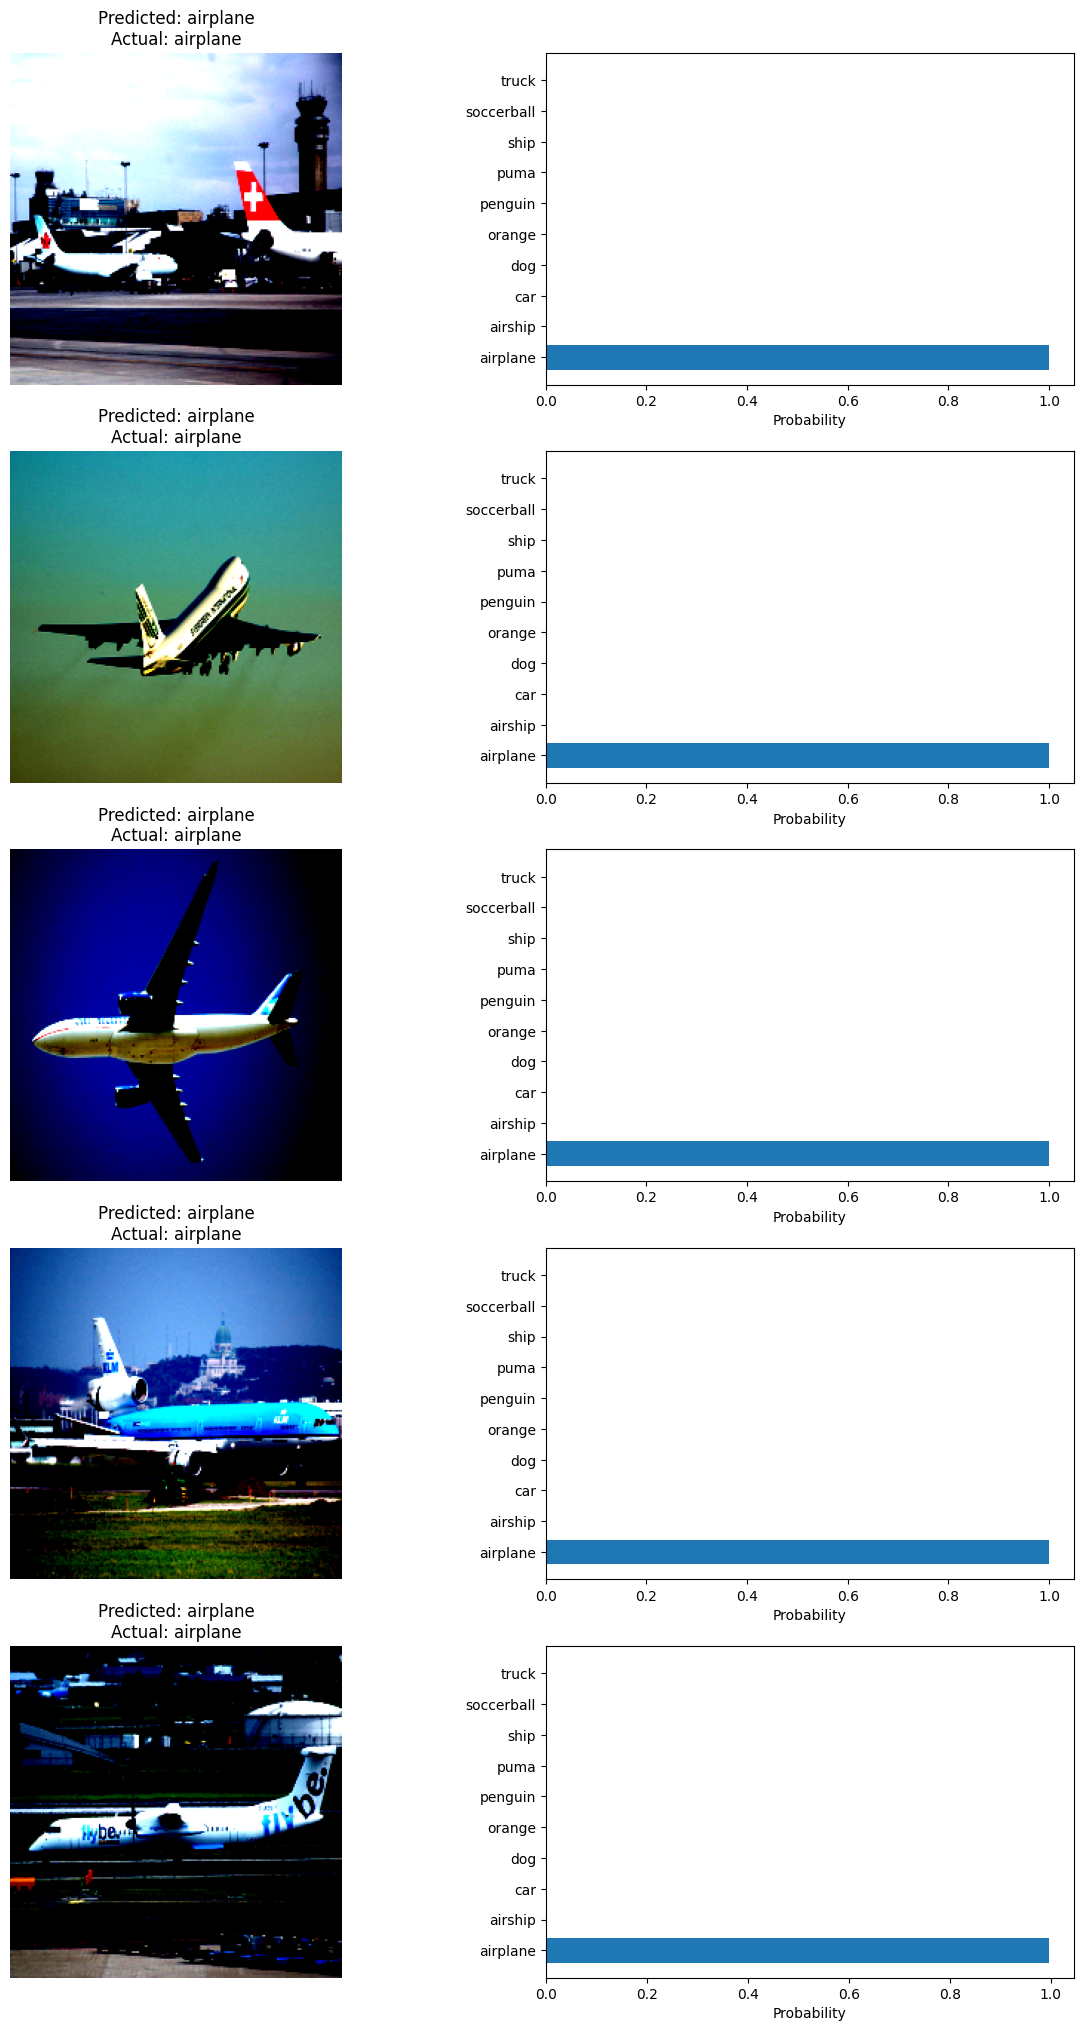

In [31]:
# Assuming class_names is a list of class names corresponding to the dataset
class_names = train_dataset.classes

# Visualize predictions on validation set
visualize_predictions(model_vgg16, val_loader, device, class_names, num_images=5)